In [ ]:
!pip install transformers
!pip install pandas==1.5.3
!pip install datasets

In [ ]:
HF_TOKEN=123

In [ ]:
import transformers
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
from sklearn.model_selection import train_test_split

In [ ]:
save_to_hub=True
new_repo=False

source_modelname="roneneldan/TinyStories-2Layers-33M"
modelpath = '/kaggle/working/'
datapath_scraped = "/kaggle/input/wholesomegreentexts-deduplicated/deduplicated_verified.csv"
datapath_generated = "/kaggle/input/generated-greentexts/generated.csv"
data_path_huggingface = "maxmyn/wholesome_greentext_239k"
SAVE_MODEL_NAME="maxmyn/tiny-all-wholesome-greentexts-2Layer-33M"
train_data_size =.9

In [ ]:
if new_repo:
    from huggingface_hub import create_repo
    create_repo(SAVE_MODEL_NAME, token=HF_TOKEN)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(source_modelname)
gpt = AutoModelForCausalLM.from_pretrained(source_modelname)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
dataset = load_dataset(data_path_huggingface)
data = pd.DataFrame(dataset['train']) #There is only the `train` data on HF, no tts.
train_data, test_data = train_test_split(data, test_size=1-train_data_size)


In [ ]:
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token

'<|endoftext|>'

In [ ]:
# Training Parameters
num_epochs = 7

lr = 1e-5
wd = 0.1
adam_beta1 = 0.9
adam_beta2 = 0.95
context_length = 512
batch_size = 8
gradient_accumulation_steps = 16

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CSVDataset(Dataset):
    def __init__(self, pd_dataframe, tokenizer, max_length=512):
        self.tokenizer = tokenizer
        self.max_length = max_length
        sequence_start_token = "<|4chanGtxStart|>"
        separator = str(tokenizer.eos_token) + sequence_start_token
        concatenated_text = separator.join([gtx.lower() for gtx in pd_dataframe['greentexts'].tolist()])
        self.chunks = self._split_into_chunks(concatenated_text, sequence_start_token)

    def _split_into_chunks(self, text, sequence_start_token):
        tokens = self.tokenizer.tokenize(text) #returns list of tokens
        chunk_size = self.max_length - 1 - len(self.tokenizer.tokenize(sequence_start_token))  # -1 for <endofText> token
        return [tokens[i:i + chunk_size] for i in range(0, len(tokens), chunk_size)]

    def __len__(self):
        return len(self.chunks)

    def __getitem__(self, idx):
        chunk = self.chunks[idx]
        # Join the tokens and add the endoftext token
        chunk_text = self.tokenizer.convert_tokens_to_string(chunk) + tokenizer.eos_token
        inputs = self.tokenizer(chunk_text, max_length=self.max_length, padding='max_length', truncation=True, return_tensors="pt")
        input_ids = inputs['input_ids'].squeeze(0)  # Remove batch dimension
        attention_mask = inputs['attention_mask'].squeeze(0)
        return {'input_ids': input_ids, 'attention_mask': attention_mask}

train_dataset = CSVDataset(train_data, tokenizer, max_length=context_length)
test_dataset = CSVDataset(test_data, tokenizer, max_length=context_length)

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

Token indices sequence length is longer than the specified maximum sequence length for this model (8271586 > 2048). Running this sequence through the model will result in indexing errors


In [ ]:
def print_gpu_memory():
    allocated = torch.cuda.memory_allocated()
    reserved = torch.cuda.memory_reserved()
    print(f"Allocated memory: {allocated / 1024**3:.4f} GB")
    print(f"Reserved memory: {reserved / 1024**3:.4f} GB")

In [ ]:
import torch
import torch.nn.functional as F
from torch.optim import Adam
from tqdm.auto import tqdm
from torch.cuda.amp import GradScaler, autocast
import gc

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def training_loop(gpt, train_dataloader, test_dataloader, num_epochs):
  train_losses = []
  test_losses = []


  gpt.to(device)
  scaler = GradScaler()

  num_training_steps = num_epochs * len(train_dataloader)
  progress_bar = tqdm(range(num_training_steps), desc='Training Progress')

  # Setup optimizer with the new hyperparameters
  optimizer = Adam(gpt.parameters(), lr=lr, betas=(adam_beta1, adam_beta2), weight_decay=wd)
  optimizer.zero_grad()
  torch.cuda.empty_cache()


  for epoch in range(num_epochs):
      gpt.train()
      train_loss = 0
      for step, batch in enumerate(train_dataloader):
          batch = {k: v.to(device) for k, v in batch.items()}
          with autocast():
              out = gpt(**batch)
              loss = F.cross_entropy(out.logits[:, :-1, :].flatten(0, -2), batch['input_ids'][:, 1:].flatten(), reduction='mean', label_smoothing=0.1)
          scaler.scale(loss).backward()

          # Step the optimizer every 'gradient_accumulation_steps' steps
          if (step + 1) % gradient_accumulation_steps == 0:
              for param in gpt.parameters():
                  param.grad /= gradient_accumulation_steps
              scaler.step(optimizer)
              scaler.update()
              optimizer.zero_grad()


          train_loss += loss.item()
          del loss, out
          progress_bar.update(1)

      avg_train_loss = train_loss / len(train_dataloader)
      train_losses.append(avg_train_loss)

      gpt.eval()
      test_loss = 0
      with torch.no_grad():
          for batch in test_dataloader:
              batch = {k: v.to(device) for k, v in batch.items()}
              out = gpt(**batch)
              loss = F.cross_entropy(out.logits[:, :-1, :].flatten(0, -2), batch['input_ids'][:, 1:].flatten(), reduction='mean', label_smoothing=0.1)
              test_loss += loss.item()
      avg_test_loss = test_loss / len(test_dataloader)
      test_losses.append(avg_test_loss)

      torch.cuda.empty_cache()
      gc.collect()


      # Update progress bar
      progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_train_loss:.4f}")
      print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")
      print_gpu_memory()

  return gpt, train_losses, test_losses



In [ ]:
def plot_loss_curve(train_losses, test_losses):
  plt.plot(train_losses, label='Training Loss')
  plt.plot(test_losses, label='Testing Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()


Training Progress:   0%|          | 0/14420 [00:00<?, ?it/s]

Epoch 1/7 - Train Loss: 5.5410, Test Loss: 4.7823
Allocated memory: 1.9229 GB
Reserved memory: 3.1758 GB
Epoch 2/7 - Train Loss: 4.5055, Test Loss: 4.2749
Allocated memory: 1.9229 GB
Reserved memory: 2.7988 GB
Epoch 3/7 - Train Loss: 4.1390, Test Loss: 4.0483
Allocated memory: 1.9229 GB
Reserved memory: 2.8301 GB
Epoch 4/7 - Train Loss: 4.0023, Test Loss: 3.9693
Allocated memory: 1.9229 GB
Reserved memory: 2.7988 GB
Epoch 5/7 - Train Loss: 3.9470, Test Loss: 3.9323
Allocated memory: 1.9229 GB
Reserved memory: 2.8613 GB
Epoch 6/7 - Train Loss: 3.9208, Test Loss: 3.9154
Allocated memory: 1.9229 GB
Reserved memory: 2.8613 GB
Epoch 7/7 - Train Loss: 3.9103, Test Loss: 3.9116
Allocated memory: 1.9229 GB
Reserved memory: 2.8613 GB
train_losses [5.540976654441612, 4.505535437991318, 4.139035057095648, 4.002275754757298, 3.947030690457057, 3.920778923242995, 3.9102927011193582]
test_losses [4.782302831458212, 4.274932107550608, 4.048279240662354, 3.969264251175926, 3.93227776585708, 3.91539109

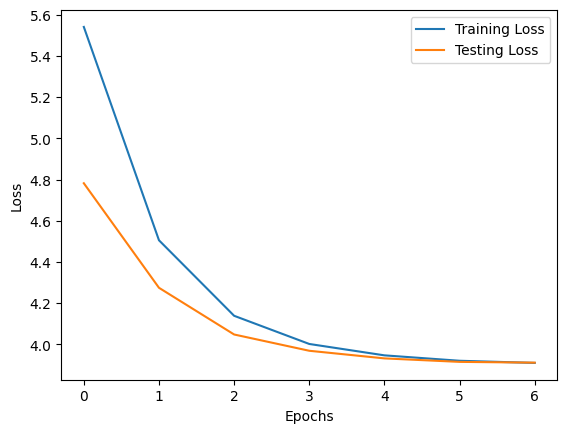

In [ ]:
gpt, train_losses, test_losses = training_loop(gpt, train_dataloader, test_dataloader, num_epochs)
print("train_losses", train_losses)
print("test_losses", test_losses)
plot_loss_curve(train_losses, test_losses)

In [ ]:
gpt.eval()
for i in range(15):
    with torch.no_grad():
      prompt = tokenizer("<|4chanGtxStart|>", truncation=True, padding=True, max_length=context_length, return_tensors='pt')
      prompt = {key: value.to(device) for key, value in prompt.items()}
      out = gpt.generate(**prompt, max_length=context_length, top_k=50, top_p=0.9, temperature=.8, do_sample=True, repetition_penalty = 1.2, num_beams=1)
      print(tokenizer.decode(out[0]))
    print("---")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


<|4chanGtxStart|> try to save a toy car
Featuresshadowinging it
> become as a hero<|endoftext|>
---
<|4chanGtxStart|> see a magical transformation
> discover a wizard
> make an enchanted lamp that grants you one of your powers
> have the best luck<|endoftext|>
---


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


<|4chanGtxStart|> try to set out a new DVD player
> it plays for hours
> it says, 'you'll have all your favorite video'
> thank you tablet<|endoftext|>
---
<|4chanGtxStart|> find a secret passage to slay of the jungle
> discover magical creatures that lives in caves
> become their own and never want<|endoftext|>
---
<|4chanGtxStart|> be me
> find a spaceship land where we meet alien friends and become friends with unexpected adventure in the galaxy<|endoftext|>
---


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


<|4chanGtxStart|> embark on a magical journey through forests
> discover the beautiful land of candy gardens, the forest giants and become the most precious king of the world.

<|endoftext|>
---
<|4chanGtxStart|> receive a new coloring app
> start drawing with colorful pictures on the paper
> thank you paper is a masterpiece<|endoftext|>
---
<|4chanGtxStart|> be in a new restaurant
> eat pizza with friends
> feel like the pizza maker<|endoftext|>
---


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


<|4chanGtxStart|> embark on a magical adventure
> find hidden treasure chest
> keep it to its secret island<|endoftext|>
---
<|4chanGtxStart|> accidentally set off on a road trip with a map
> stumble upon the wrong way to end up in the desert where it's actually a dangerous route for an actual adventurer journey.<|endoftext|>
---


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


<|4chanGtxStart|> find an ancient map leading to a treasure chest
> discover an old map that leads the map of all the treasure in the world<|endoftext|>
---
<|4chanGtxStart|> see a magical creature
> he can turn into an ancient treehouse<|endoftext|>
---
<|4chanGtxStart|> find a magic wand
> wishes for the future future<|endoftext|>
---


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


<|4chanGtxStart|> see a big mansion
> mansion with a huge giant cake and lots of candies and chocolateummies! It's not only a party<|endoftext|>
---
<|4chanGtxStart|> find a toy robot
> it starts playing with me on my toys<|endoftext|>
---


In [ ]:
if save_to_hub:
    gpt.push_to_hub(SAVE_MODEL_NAME, token=HF_TOKEN)
    tokenizer.push_to_hub(SAVE_MODEL_NAME, token=HF_TOKEN)

model.safetensors:   0%|          | 0.00/315M [00:00<?, ?B/s]